In [1]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

/home/okozyn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Normalize array from 0 to 1
def normalize(target_array):
    target_array -= target_array.min()
    normalized_array = np.divide(target_array, target_array.max())
    return normalized_array


In [6]:
from tempfile import mkstemp
from shutil import move
from os import fdopen, remove

def replace(file_path, pattern, subst):
    """
    Replace strings in a file.
    
    Parametrs:
        pattern (str, iterable): pattern to replace.
        subst (str, iterable): subtitution.
    
    """
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

#replace("TransformParameters.0.txt","(FinalBSplineInterpolationOrder 3)","(FinalBSplineInterpolationOrder 0)")

In [3]:
# Path to test images
test_dir = "./test-set/testing-images"
# Path to image to register to
mean_im = './MNITemplateAtlas/template.nii.gz'
# Path to affine parameters
affine_path = "./training-set/par0000affine.txt"
bspline_path = "./training-set/par0000bspline.txt"

test_ims = [f for f in listdir(test_dir)]

# for f in test_ims:
#     file_name = f[:-7]
#     dir_name = f"./test-set/registration-results/{file_name}"    
#     os.mkdir(dir_name)

In [8]:
# Write commands for elastix registration
with open("test_registration", 'w+') as out_f:
    
    for f in test_ims:
        test_file_path = f"./test-set/testing-images/{f}" 
        result_path = f"./test-set/registration-results/mni_templates/{f[:-7]}"
        fmask_path = f"./test-set/testing-mask/{f[:-7]}_1C.nii.gz"
        cmd = f"elastix -f {test_file_path} -m {mean_im} -out {result_path} -fMask {fmask_path} -p {affine_path} -p {bspline_path}\n"
        out_f.write(cmd)


In [5]:
# Make directories for transformed template images
for f in test_ims:
    file_name = f[:-7]
    dir_name = f"./test-set/registration-results/mni_atlases/{file_name}"    
    #os.mkdir(dir_name)

In [6]:
# List of label files to transform
testing_labels_dir = "./test-set/testing-labels"
test_labels = [f for f in listdir(testing_labels_dir)]

In [8]:
#Change line "(FinalBSplineInterpolationOrder 3)" in Transform parameters files
bad_files = []

for f in test_ims:
    try:
        parameters0_path = f"./test-set/registration-results/mni_templates/{f[:-7]}/TransformParameters.0.txt"
        parameters1_path = f"./test-set/registration-results/mni_templates/{f[:-7]}/TransformParameters.1.txt"
        
        replace(parameters0_path,"(FinalBSplineInterpolationOrder 3)","(FinalBSplineInterpolationOrder 0)")
        replace(parameters0_path, '(ResultImagePixelType "short")', '(ResultImagePixelType "float")')
        replace(parameters0_path, '(ResultImageFormat "nii")', '(ResultImageFormat "nii.gz")')
        
        replace(parameters1_path,"(FinalBSplineInterpolationOrder 3)","(FinalBSplineInterpolationOrder 0)")
        replace(parameters1_path, '(ResultImagePixelType "short")', '(ResultImagePixelType "float")')
        replace(parameters1_path, '(ResultImageFormat "nii")', '(ResultImageFormat "nii.gz")')
        
    except IOError as e:
        print(e)
        bad_files.append(f)

print(bad_files)

[]


In [33]:
# Write commands for transformix transformation
with open("test_transformation", 'w+') as out_f:
    
    for f in test_labels:
        test_labels_path = f"./test-set/testing-labels/{f}" 
        result_path = f"./test-set/registration-results/transformed-labels/{f[:-10]}"
        parameters_path = f"./test-set/registration-results/affine+bspline/{f[:-10]}/TransformParameters.1.txt"
        cmd = f"transformix -in {test_labels_path} -out {result_path} -tp {parameters_path}\n"
        out_f.write(cmd)

In [36]:
for f in test_labels:
    parameters_path = f"./test-set/registration-results/affine+bspline/{f[:-10]}/TransformParameters.1.txt"
    original_line = f'(InitialTransformParametersFileName "./test-set/registration-results/{f[:-10]}/TransformParameters.0.txt")'
    replace_line = f'(InitialTransformParametersFileName "./test-set/registration-results/affine+bspline/{f[:-10]}/TransformParameters.0.txt")'
    replace(parameters_path, original_line, replace_line)

1005
0.0
1.0


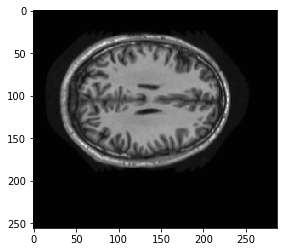

1003
0.0
1.0


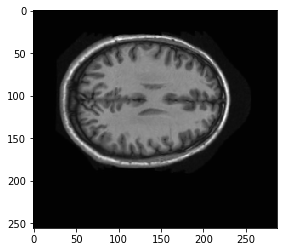

1004
0.0
1.0


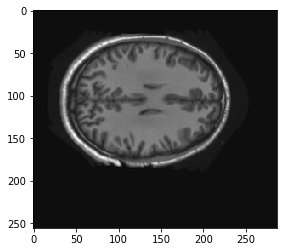

1125
0.0
1.0


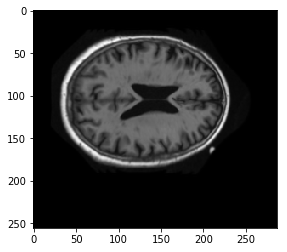

1122
0.0
1.0


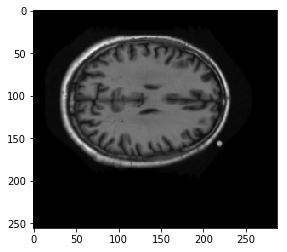

1113
0.0
1.0


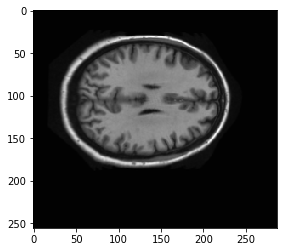

1101
0.0
1.0


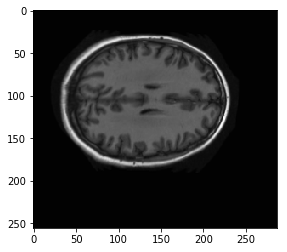

1107
0.0
1.0


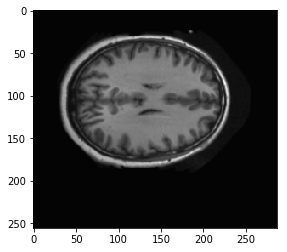

1019
0.0
1.0


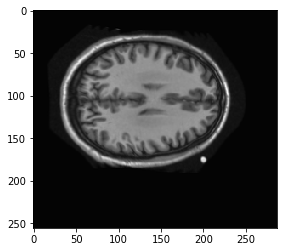

1018
0.0
1.0


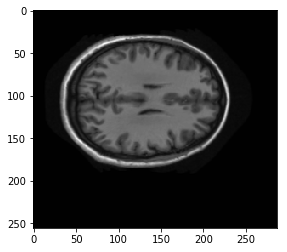

1039
0.0
1.0


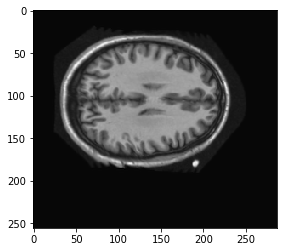

1038
0.0
1.0


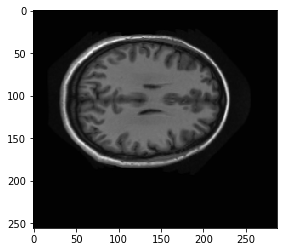

1119
0.0
1.0


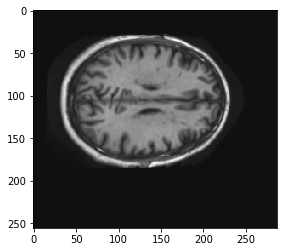

1110
0.0
1.0


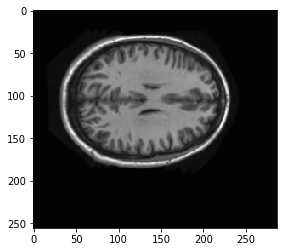

1128
0.0
1.0


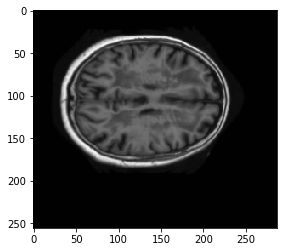

1116
0.0
1.0


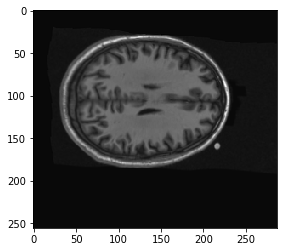

1104
0.0
1.0


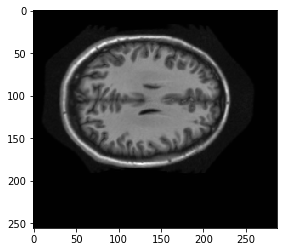

1025
0.0
1.0


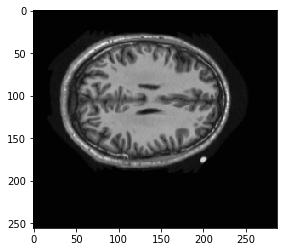

1024
0.0
1.0


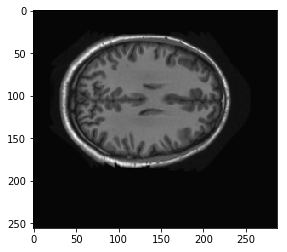

1023
0.0
1.0


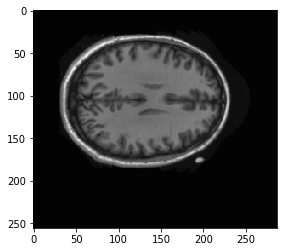

In [45]:
# Set path to registered images folder and import nii into python
data_dir = "./test-set/registration-results/affine+bspline/"
onlydirs = [f for f in listdir(data_dir) if isdir(join(data_dir, f))]

for dir in onlydirs:
    print(dir)
    im = join(data_dir, dir,'result.1.nii')
    nii_img = nib.load(im)
    nii_data = nii_img.get_data()
    nii_data = normalize(nii_data)
    
    print(nii_data.min())
    print(nii_data.max())
    plt.imshow(nii_data[:,:,150], cmap = "gray")
    plt.show()

In [16]:
# Path to test images
test_dir = "./test-set/testing-images"

# Path to atlases
atlas_folder = './MNITemplateAtlas'
csf_atlas_path = 'CSF_probs.nii.gz'
gm_atlas_path = 'GM_probs.nii.gz'
wm_atlas_path = 'WM_probs.nii.gz'

test_imgs_names = [f[:-7] for f in listdir(test_dir)]
    

# Write commands for transformix transformation
with open("test_transformation", 'w+') as out_f:
    for atlas in (csf_atlas_path, gm_atlas_path, wm_atlas_path):
        for f in test_imgs_names:
            atlas_path = join(atlas_folder, atlas)
            result_path = f"./test-set/registration-results/mni_atlases/{f}/{atlas[:-13].lower()}"
            parameters_path = f"./test-set/registration-results/mni_templates/{f}/TransformParameters.1.txt"
            cmd = f"transformix -in {atlas_path} -out {result_path} -tp {parameters_path}\n"
            out_f.write(cmd)
            os.mkdir(result_path)
        out_f.write("\n")

# with open("git_help", "w+") as out_file:
#     for f in test_imgs_names:
#         out_file.write(f"git checkout -- test-set/registration-results/affine+bspline/{f}/TransformParameters.0.txt\n")
#         out_file.write(f"git checkout -- test-set/registration-results/affine+bspline/{f}/TransformParameters.1.txt\n")
